In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
from xlrd.biffh import BIFF_FIRST_UNICODE
import xlwt
from scipy.stats import norm
from cycler import cycler
import seaborn as sns
import product_component_model as pcm
custom_cycler = cycler(color=sns.color_palette('Paired', 20)) #'Set2', 'Paired', 'YlGnBu'

In [2]:
# Loading data
path = os.getcwd()
stock = pd.read_excel(path+"/data/Global_stock.xlsx") 
shares = pd.read_excel(path+"/data/motorEnergy_shares.xlsx")

# Calculating gloal BEV stock according to IEA Net Zero scenario and BAU stock projections
data = stock.Stock.values * shares.Share.values/1000000 # Convert to millions

# We store the time and inflows values in two lists
time = stock.Year.values


(0.0, 100.0)

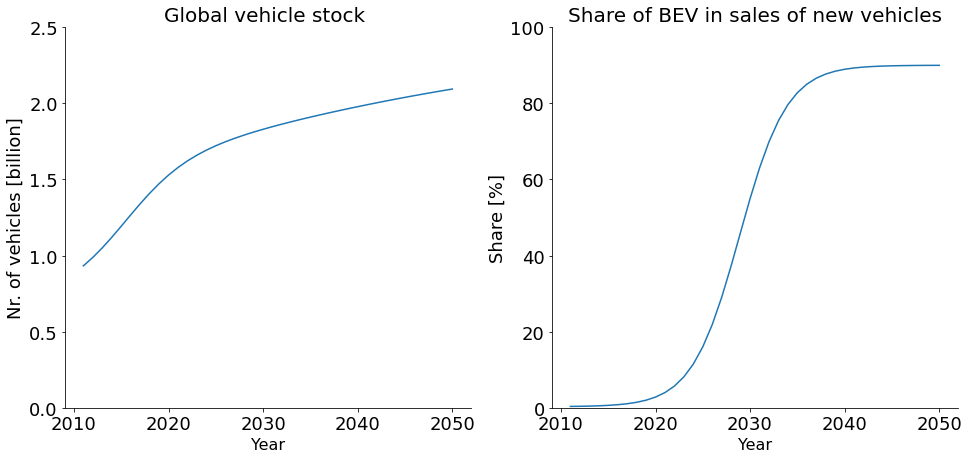

In [3]:
fig, ax = plt.subplots(1,2, figsize=(16,7), sharey=False)
#ax[0].set_prop_cycle(custom_cycler)
ax[0].plot(time, 
        stock.Stock.values/1000000000, label='Global vehicle stock')
ax[0].set_ylabel('Nr. of vehicles [billion]',fontsize =18)
right_side = ax[0].spines["right"]
right_side.set_visible(False)
top = ax[0].spines["top"]
top.set_visible(False)
#ax[0].legend(loc='upper left',prop={'size':15})
ax[0].set_title('Global vehicle stock ', fontsize=20)
ax[0].set_xlabel('Year',fontsize =16)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylim([0,2.5])
#ax[1].set_prop_cycle(custom_cycler)
ax[1].plot(time, 
        shares.Share.values*100, label='BEV penetration')
ax[1].set_ylabel('Share [%]',fontsize =18)
right_side = ax[1].spines["right"]
right_side.set_visible(False)
top = ax[1].spines["top"]
top.set_visible(False)
#ax[1].legend(loc='upper left',prop={'size':15})
ax[1].set_title('Share of BEV in sales of new vehicles', fontsize=20)
ax[1].set_xlabel('Year',fontsize =16)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylim([0,100])


# Case 1

We begin by introducing the case study in the conventional MFA way of modelling products. One lifetime is used to determine the dynamics of both goods, EVs and LIBs, at the global level. Since this lifetime should account for all failures, including battery failures, crashes, and lifestyle choices, we choose a lifetime of 16 years with a standard deviation of 4 years in a normal distribution. This should be in line with literature, considering that here we use a value for the global average. 

Thus, we use the ProductComponentModel library and select case 1, which uses the lifetime of the product and the stock as only input to determine the system dynamics. 

In [4]:
# Define lifetime and standard deviation
lt = np.array([16])
sd = np.array([4])

# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt, 'StdDev': sd})

# Compute model using case 1 assumptions. The output variables are sc_pr, sc_cm, i_pr, i_cm, oc_pr, oc_cm
# Keep in mind the output variables have a time-cohort resolution and need to be aggregated to calculate the total yearly value
# Instead of unpacking the values, you can also use Model.sc_pr and so on instead (see plot)
stock_ev, stock_lib, inflow_ev, inflow_lib, outflow_ev, outflow_lib = Model.case_1()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', outflow_ev, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', outflow_lib, shares.Share.values)
Model.i_pr = inflow_ev * shares.Share.values
Model.i_cm = inflow_lib * shares.Share.values


## Plotting the results

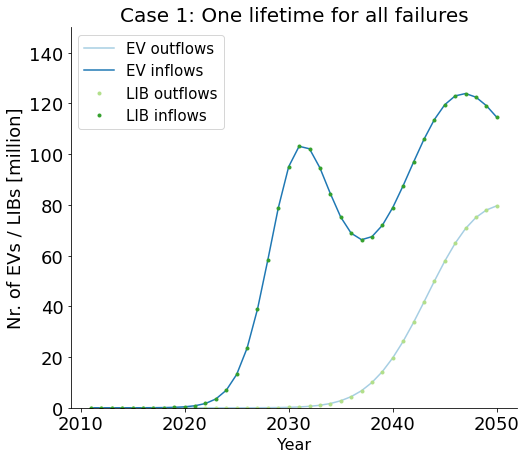

In [5]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
ax.plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax.plot(Model.t, Model.i_pr, label='EV inflows')
ax.plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax.plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax.set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
ax.legend(loc='upper left',prop={'size':15})
ax.set_title('Case 1: One lifetime for all failures', fontsize=20)
ax.set_xlabel('Year',fontsize =16)
ax.set_ylim([0,150])
ax.tick_params(axis='both', which='major', labelsize=18)

# Case 2
Given that the expected technical lifetime of the battery is often expected to be lower than the lifetime of the vehicles, it would be reasonable to assume that some of the EVs eventually get a battery replacement. Without considering their technical lifetime explicitly, one could introduce a constant replacement rate at which batteries are exchanged. Such case is depicted here. \

In addition to the input needed for case 1, we here also need a replacement rate r

In [6]:
# Define lifetime and standard deviation
lt = np.array([16])
sd = np.array([4])

# Define replacement rate
r = 0.2

# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt, 'StdDev': sd}, r=r)

# Compute model using case 2 assumptions. The output variables are sc_pr, sc_cm, i_pr, i_cm, oc_pr, oc_cm
# Keep in mind the output variables have a time-cohort resolution and need to be aggregated to calculate the total yearly value
# Instead of unpacking the values, you can also use Model.sc_pr and so on instead (see plot)
Model.case_2()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', outflow_ev, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', outflow_lib, shares.Share.values)
Model.i_pr = inflow_ev * shares.Share.values
Model.i_cm = inflow_lib * shares.Share.values

## Plotting the results

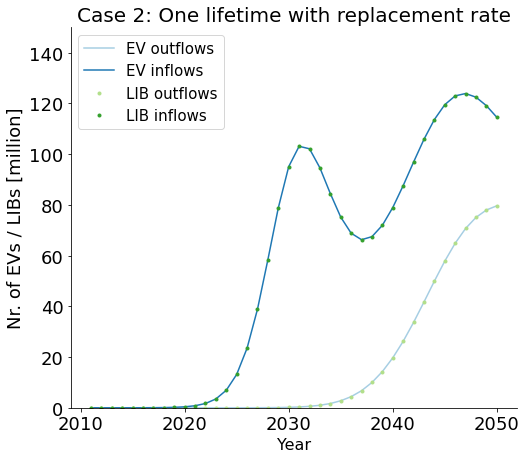

In [7]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
ax.plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax.plot(Model.t, Model.i_pr, label='EV inflows')
ax.plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax.plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax.set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
ax.legend(loc='upper left',prop={'size':15})
ax.set_title('Case 2: One lifetime with replacement rate', fontsize=20)
ax.set_xlabel('Year',fontsize =16)
ax.set_ylim([0,150])
ax.tick_params(axis='both', which='major', labelsize=18)

# Case 3 
As can be seen above, in the case of products with a lifetime and with a growing stock, the battery replacement rate approach can lead to an underestimation of the battery ouflows in the early years and an overestimation later on. Therefore, a more refined approach that considers the technical lifetime of the batteries to calculate the time of their outflow can be introduced. In analogy to case 1, we consider here that the battery is prohivitively expensive to replace, which means that if the battery fails, so does the EV. Corresondingly, if the EV fails, the battery is considered to be scrapped as well. 

Under the current regulatory environment, EOL batteries are indeed considered hazardous waste which makes their handling and reverse logistics rather expensive and complicated. This barrier may lead to the situation stated above, where batteries in good state of health are not reused instead being scrapped and underused. These batteries might be good candidate for second life batteries for stationary applications, but here again a regulatory environment that encourages reuse and facilitates the handling of undamaged batteries is required. 

Since now the EV lifetime does not include battery failure, we can use a value that is closer to that of the EVs technical lifetime. Considering that EVs have significantly less moving parts and do not have the main part causing ICE obsolescence - the engine - we assume a rather long lifetime of 20 years and a standard deviation of 5 years for this product. LIBs are usually covered by a 8 - 10 year warranty, but recent data has shown that this might be a rather conservative figure. We therefore assume a lifetime of 12 years instead, and a standard deviation of 4 years. 

In [8]:
# Define lifetime and standard deviation of EVs
lt_pr = np.array([16])
sd_pr = np.array([4])
# Define lifetime and standard deviation of LIBs
lt_cm = np.array([12])
sd_cm = np.array([3])


# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm})

# Compute model using case 3 assumptions. The output variables are sc_pr, sc_cm, i_pr, i_cm, oc_pr, oc_cm
# Keep in mind the output variables have a time-cohort resolution and need to be aggregated to calculate the total yearly value
# Instead of unpacking the values, you can also use Model.sc_pr and so on instead (see plot)
Model.case_3()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.o_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.o_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

## Plotting results

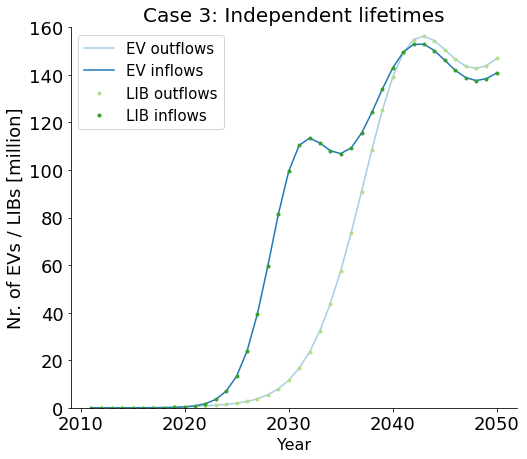

In [9]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
ax.plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax.plot(Model.t, Model.i_pr, label='EV inflows')
ax.plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax.plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax.set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
ax.legend(loc='upper left',prop={'size':15})
ax.set_title('Case 3: Independent lifetimes', fontsize=20)
ax.set_xlabel('Year',fontsize =16)
ax.set_ylim([0,160])
ax.tick_params(axis='both', which='major', labelsize=18)

# Case 4

As stated above, not allowing for battery reuse may mean that some batteries go underused. To avoid this outcome, it would be desirable to reuse batteries in other EVs where possible. Currently, there is great secrecy and variations among automobile manufacturers and batteries due to the competitiveness of the industry, making battery replacement in used EVs a complicated affair. Moreover, automobile manufacturers do not currently have any incentive to prolong their EV lifetimes by desining for easy battery replacement. As a consequence, in combination with high LIB prices and no sceme for reuse, battery replacemets are not common practice.

If the battery lifetime were long enough, or a good collection scheme for e.g. crashed vehicle batteries were in place, a situation could arise in which batteries in good state of health are taken back to the manufacturer and reused for new vehicles. This would reduce the demand for new batteries and alleviate the underuse of resources in batteries. For such scheme to work, the automotive manufacturers need to ensure that the battery will function for at least the warrany period. Therefore, in this model, we assume that batteries which have a remaining expected technical lifetime of 8 years are reused in new vehicles. 

The results show that such a requirement to ensure the lifetime of the battery for at least 8 years is too stringent and causes a very marginal reduction in the LIB demand. 

In [10]:
# Define lifetime and standard deviation of EVs
lt_pr = np.array([15])
sd_pr = np.array([5])
# Define lifetime and standard deviation of LIBs
lt_cm = np.array([20])
sd_cm = np.array([4])

# Define amount of time that the battery should still be useful for
tau_cm = 3 # Assuming a warranty of 8 years


# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, reuse_coeff=1, tau_pr=3)

# Compute model using case 4 assumptions. The output variables are sc_pr, sc_cm, i_pr, i_cm, oc_pr, oc_cm
# Keep in mind the output variables have a time-cohort resolution and need to be aggregated to calculate the total yearly value
# Instead of unpacking the values, you can also use Model.sc_pr and so on instead (see plot)
Model.case_4()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

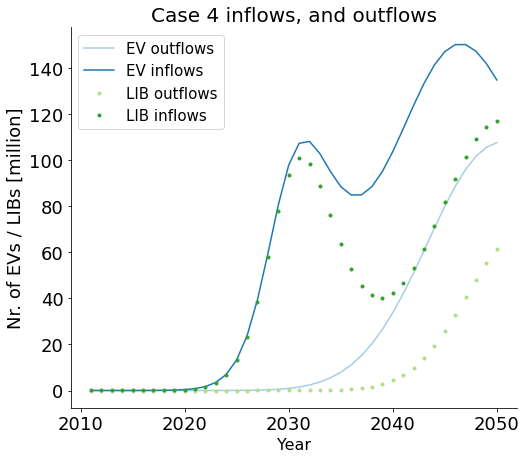

In [11]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
ax.plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax.plot(Model.t, Model.i_pr, label='EV inflows')
ax.plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax.plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax.set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
ax.legend(loc='upper left',prop={'size':15})
ax.set_title('Case 4 inflows, and outflows', fontsize=20)
ax.set_xlabel('Year',fontsize =16)
#ax.set_ylim([0,5])
ax.tick_params(axis='both', which='major', labelsize=18)

In [12]:
Model.reused_cm

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.05106168e-03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.07892519e-03,  6.66098031e-04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.13804169e-04, -2.90969496e-04, -8.83105926e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.53451370e-04, -1.32795865e-04, -4.24072237e-04, ...,
         1.97413059e-01,  0.00000000e+00,  0.00000000e+00],
       [-1.46273119e-04, -5.76764809e-05, -1.93543554e-04, ...,
         3.44964666e-01,  1.90180889e-01,  0.00000000e+00]])

# Case 5 

A current trend in automotive manufacturers shows a shift towards digitalization in the industry. VW has announced that all of their models will contain "Air software updates" allowing the entire EV fleet to keep state of the art software. Tesla also has this approach well established. This paradigm shift may lead to EV owners to wish to use their vehicles as long as possible and reduce the choices to exchange the vehicle for a new one for lifestyle reasons. In this case, battery repolacement demand could rise and consumers may expect their vehicle manufacturers to allow for easy battery replacements. To lower the price threshold of new battries, which is still substancial, policimakers should introduce subsidies for batteries in addition to the many subsidies that are already in place for EVs, causing a synergistic effect of resource utilization and transition to e-mobility. In this model, we assume that only new batteries are purchased for battery replacements, as reverse logistics are considered a major barrier. 

As a criteria for battery replacements, here we will assume that not all vehicle owners whith a faulty battery will purchase a replacement. Specifically, we will assume that only the share of vehicles that will still be in the fleet for a specific amount of time will purchase a replacement battery, the others will scrap their vehicles ahead of their technical lifetime limitation. Here we show the change in LIB demand depending on the threshold for EV owners to purchase a new battery. If no subsidies are in place, we assume that LIBs have a substantial price and therefore only vehicle owners that will keep their vehicles for at least 8 years will purchase a new battery. If subsidies are in place, we assume that the threshold will be lowered to 5 years. 

In the results it can be seen that while the demand of LIBs is not affected through the widespread introduction of battery replacements in vehicles, the demand for vehicles themselves can be drastically reduced.

In [13]:
# Define lifetime and standard deviation of EVs
lt_pr = np.array([20])
sd_pr = np.array([5])
# Define lifetime and standard deviation of LIBs
lt_cm = np.array([12])
sd_cm = np.array([4])

# Define amount of time that the battery should still be useful for
tau_pr = 5 # Assuming a warranty of 8 years


# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=tau_pr)

# Compute model using case 1 assumptions. The output variables are sc_pr, sc_cm, i_pr, i_cm, oc_pr, oc_cm
# Keep in mind the output variables have a time-cohort resolution and need to be aggregated to calculate the total yearly value
# Instead of unpacking the values, you can also use Model.sc_pr and so on instead (see plot)
Model.case_5()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

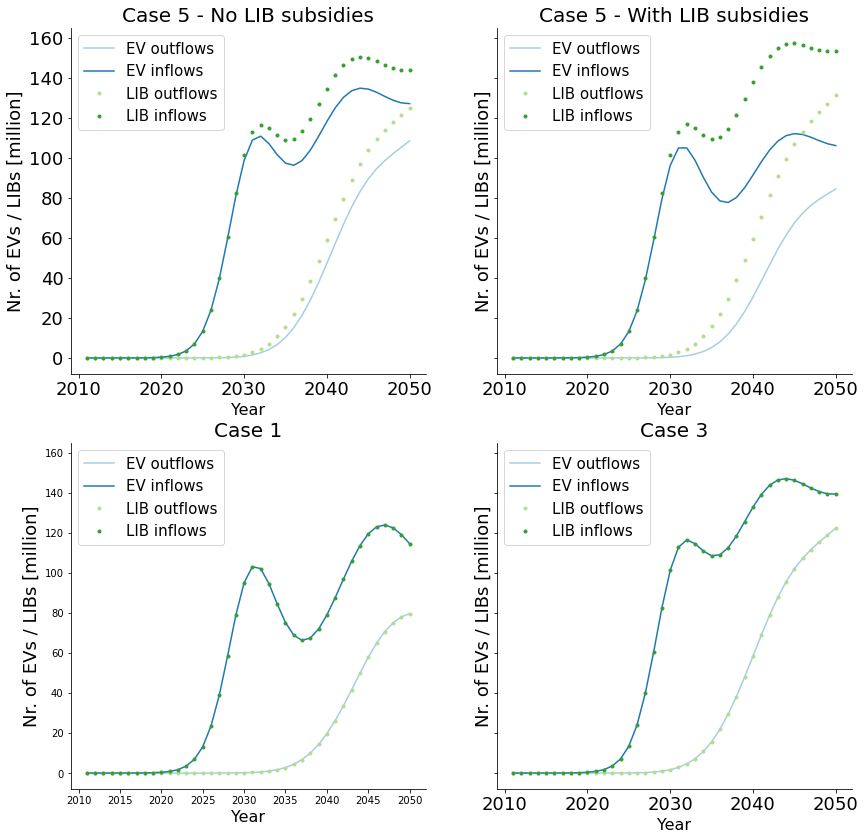

In [14]:
tau_pr = 15 # Assuming a warranty of 8 years
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=tau_pr)
Model.case_5()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

fig, ax = plt.subplots(2,2, figsize=(14,14), sharey=True)
ax[0,0].set_prop_cycle(custom_cycler)
ax[0,0].plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax[0,0].plot(Model.t, Model.i_pr, label='EV inflows')
ax[0,0].plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax[0,0].plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax[0,0].set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax[0,0].spines["right"]
right_side.set_visible(False)
top = ax[0,0].spines["top"]
top.set_visible(False)
ax[0,0].legend(loc='upper left',prop={'size':15})
ax[0,0].set_title('Case 5 - No LIB subsidies', fontsize=20)
ax[0,0].set_xlabel('Year',fontsize =16)
#ax.set_ylim([0,5])
ax[0,0].tick_params(axis='both', which='major', labelsize=18)

## Compute model with subsidies 
# Define amount of time that the battery should still be useful for
tau_pr = 10
# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=tau_pr)
Model.case_5()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

ax[0,1].set_prop_cycle(custom_cycler)
ax[0,1].plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax[0,1].plot(Model.t, Model.i_pr, label='EV inflows')
ax[0,1].plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax[0,1].plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax[0,1].set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax[0,1].spines["right"]
right_side.set_visible(False)
top = ax[0,1].spines["top"]
top.set_visible(False)
ax[0,1].legend(loc='upper left',prop={'size':15})
ax[0,1].set_title('Case 5 - With LIB subsidies', fontsize=20)
ax[0,1].set_xlabel('Year',fontsize =16)
#ax.set_ylim([0,5])
ax[0,1].tick_params(axis='both', which='major', labelsize=18)

## Compute model without replacements as in case 1
# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': np.array([16]), 'StdDev': np.array([4])}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm})
Model.case_1()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

ax[1,0].set_prop_cycle(custom_cycler)
ax[1,0].plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax[1,0].plot(Model.t, Model.i_pr, label='EV inflows')
ax[1,0].plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax[1,0].plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax[1,0].set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax[1,0].spines["right"]
right_side.set_visible(False)
top = ax[1,0].spines["top"]
top.set_visible(False)
ax[1,0].legend(loc='upper left',prop={'size':15})
ax[1,0].set_title('Case 1', fontsize=20)
ax[1,0].set_xlabel('Year',fontsize =16)

## Compute model without replacements as in case 3
# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm})

Model.case_3()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

ax[1,1].set_prop_cycle(custom_cycler)
ax[1,1].plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax[1,1].plot(Model.t, Model.i_pr, label='EV inflows')
ax[1,1].plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax[1,1].plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax[1,1].set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax[1,1].spines["right"]
right_side.set_visible(False)
top = ax[1,1].spines["top"]
top.set_visible(False)
ax[1,1].legend(loc='upper left',prop={'size':15})
ax[1,1].set_title('Case 3', fontsize=20)
ax[1,1].set_xlabel('Year',fontsize =16)
#ax.set_ylim([0,5])
ax[1,1].tick_params(axis='both', which='major', labelsize=18)

# Case 6

Finally, this case examines the consequences of reusing batteries for the automotive industry from discarded vehicles. Enabled by ambitious policies that facilitate the handling of EOL vehicle batteries in combination with widespread introduction of battery replacements, in this case LIBs can be reused in EVs after vehicle failures. In contrast to case 5, here some of the batteries that are needed for replacements come from reused batteries. We consider that in addition to the vehicle needing to be used for a certain period of time after repair, the battery needs to be useful for some years as well for the investment to be worth it. We consider that since second hand batteries could be less costly than new ones, an EV owner can decide to purchase for a period of time that is inferior to the one required for new batteries. 

In [15]:
# Define lifetime and standard deviation of EVs
lt_pr = np.array([16])
sd_pr = np.array([4])
# Define lifetime and standard deviation of LIBs
lt_cm = np.array([20])
sd_cm = np.array([6])

# Define amount of time that the battery should still be useful for
tau_pr = 5 # Assuming subsidies are in place
tau_cm = 5 # Assuming second hand batteries cheaper than new ones

# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=tau_pr, reuse_coeff= 0.3)

# Compute model using case 1 assumptions. The output variables are sc_pr, sc_cm, i_pr, i_cm, oc_pr, oc_cm
# Keep in mind the output variables have a time-cohort resolution and need to be aggregated to calculate the total yearly value
# Instead of unpacking the values, you can also use Model.sc_pr and so on instead (see plot)
Model.case_6()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

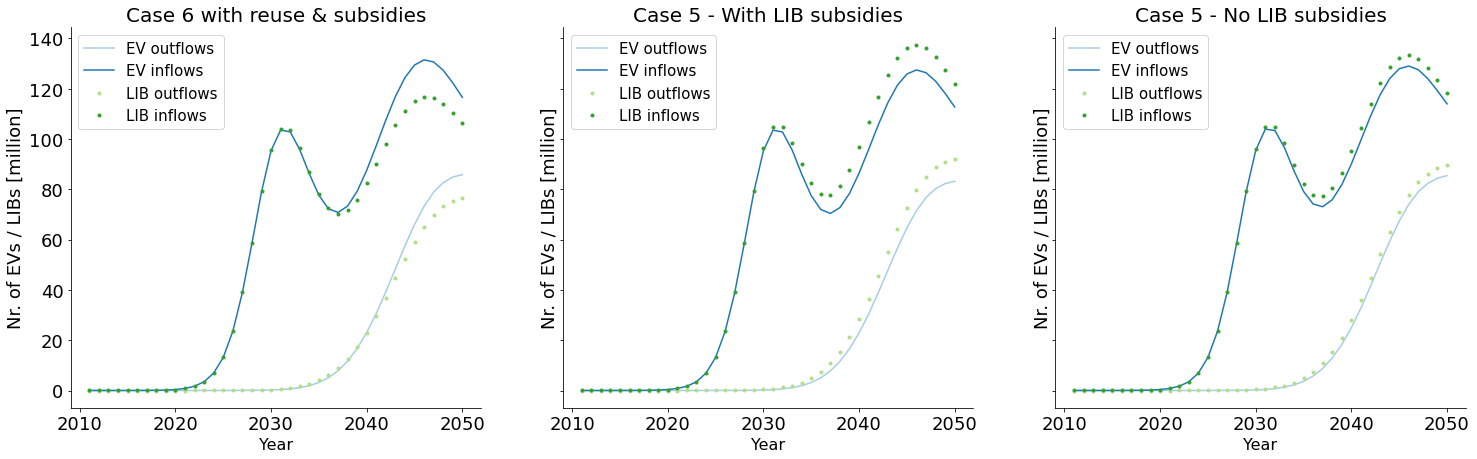

In [16]:
fig, ax = plt.subplots(1,3, figsize=(25,7), sharey=True)
ax[0].set_prop_cycle(custom_cycler)
ax[0].plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax[0].plot(Model.t, Model.i_pr, label='EV inflows')
ax[0].plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax[0].plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax[0].set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax[0].spines["right"]
right_side.set_visible(False)
top = ax[0].spines["top"]
top.set_visible(False)
ax[0].legend(loc='upper left',prop={'size':15})
ax[0].set_title('Case 6 with reuse & subsidies', fontsize=20)
ax[0].set_xlabel('Year',fontsize =16)
#ax.set_ylim([0,5])
ax[0].tick_params(axis='both', which='major', labelsize=18)

# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=tau_pr)

Model.case_5()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

ax[1].set_prop_cycle(custom_cycler)
ax[1].plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax[1].plot(Model.t, Model.i_pr, label='EV inflows')
ax[1].plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax[1].plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax[1].set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax[1].spines["right"]
right_side.set_visible(False)
top = ax[1].spines["top"]
top.set_visible(False)
ax[1].legend(loc='upper left',prop={'size':15})
ax[1].set_title('Case 5 - With LIB subsidies', fontsize=20)
ax[1].set_xlabel('Year',fontsize =16)
#ax.set_ylim([0,5])
ax[1].tick_params(axis='both', which='major', labelsize=18)

## Compute model without replacements as in case 1
# Define pcm 
tau_pr = 8 # Assuming a warranty of 8 years

Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=tau_pr)

Model.case_5()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.oc_pr = np.einsum('tc,c->tc', Model.oc_pr, shares.Share.values)
Model.oc_cm = np.einsum('tc,c->tc', Model.oc_cm, shares.Share.values)
Model.i_pr = Model.i_pr * shares.Share.values
Model.i_cm = Model.i_cm * shares.Share.values

ax[2].set_prop_cycle(custom_cycler)
ax[2].plot(time, 
        Model.oc_pr.sum(axis=1), label='EV outflows')
ax[2].plot(Model.t, Model.i_pr, label='EV inflows')
ax[2].plot(Model.t, 
        Model.oc_cm.sum(axis=1), '.', label='LIB outflows')
ax[2].plot(Model.t, Model.i_cm, '.', label='LIB inflows')
ax[2].set_ylabel('Nr. of EVs / LIBs [million]',fontsize =18)
right_side = ax[2].spines["right"]
right_side.set_visible(False)
top = ax[2].spines["top"]
top.set_visible(False)
ax[2].legend(loc='upper left',prop={'size':15})
ax[2].set_title('Case 5 - No LIB subsidies', fontsize=20)
ax[2].set_xlabel('Year',fontsize =16)
#ax.set_ylim([0,5])
ax[2].tick_params(axis='both', which='major', labelsize=18)

## Plotting heatmaps of battery and vehicle age

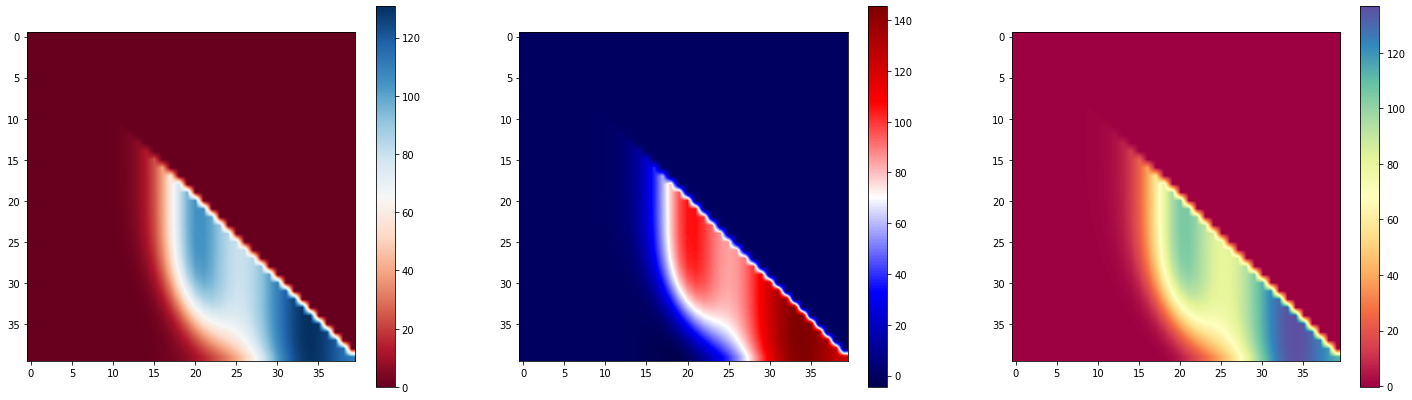

In [17]:
# Define lifetime and standard deviation of EVs
lt_pr = np.array([16])
sd_pr = np.array([4])
# Define lifetime and standard deviation of LIBs
lt_cm = np.array([16])
sd_cm = np.array([4])
r = 0.2
# Define amount of time that the battery should still be useful for
tau_pr = 6 # Assuming subsidies are in place
tau_cm = 5 # Assuming second hand batteries cheaper than new ones

fig, ax = plt.subplots(1,3, figsize=(25,7), sharey=False)
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=tau_pr, tau_cm= tau_cm, reuse_coeff=r)
Model.case_4()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.sc_cm = np.einsum('tc,c->tc', Model.sc_cm, shares.Share.values)

ax[0].imshow(Model.sc_cm, interpolation='bilinear', cmap='RdBu')
fig.colorbar(ax[0].imshow(Model.sc_cm, interpolation='bilinear', cmap='RdBu'), ax=ax[0])

# Define pcm 
Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=tau_pr)
Model.case_5()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.sc_cm = np.einsum('tc,c->tc', Model.sc_cm, shares.Share.values)

ax[1].imshow(Model.sc_cm, interpolation='bilinear', cmap='seismic')
fig.colorbar(ax[1].imshow(Model.sc_cm, interpolation='bilinear', cmap='seismic'), ax=ax[1])

Model = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=tau_pr, tau_cm= tau_cm, reuse_coeff=r)
Model.case_6()

# Since we are using the total stock as a driver, we need to multiply the results with the BEV penetration shares
Model.sc_cm = np.einsum('tc,c->tc', Model.sc_cm, shares.Share.values)

ax[2].imshow(Model.sc_cm, interpolation='bilinear', cmap='Spectral')
fig.colorbar(ax[2].imshow(Model.sc_cm, interpolation='bilinear', cmap='Spectral'), ax=ax[2])


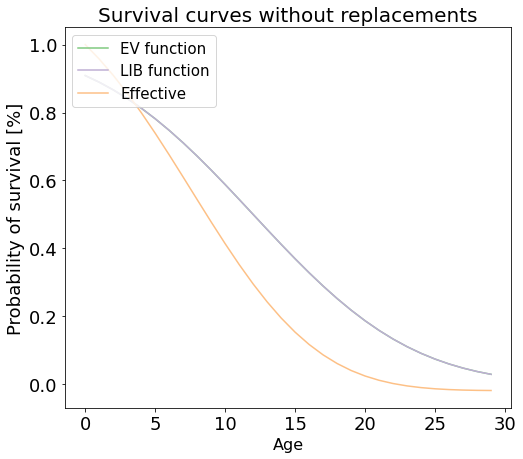

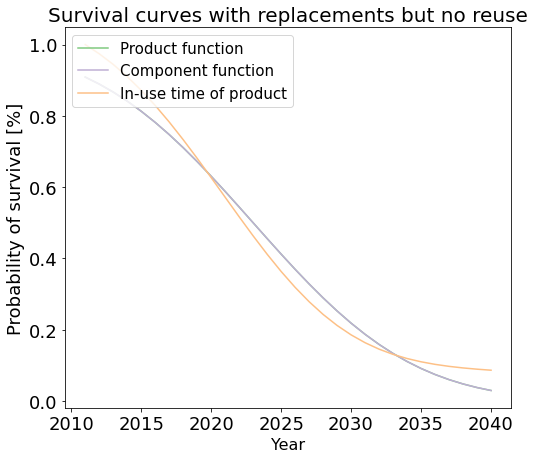

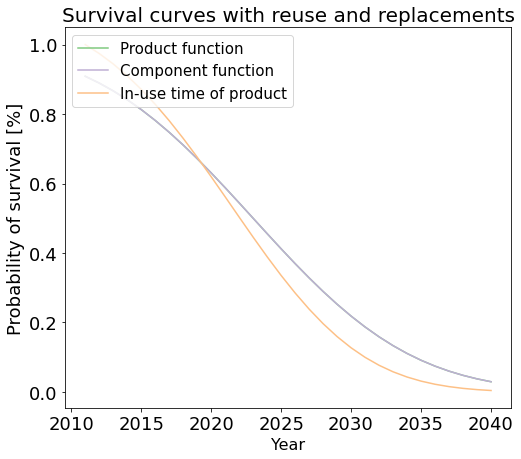

In [18]:

# Survival curves comparison
lt_pr = np.array([12])
sd_pr = np.array([9])
lt_cm = np.array([12])
sd_cm= np.array([9])
Model1 = pcm.ProductComponentModel(t=time, s_pr=data, 
                                   lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr},
                                   lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm},
                                   tau_pr=6, tau_cm= 5, reuse_coeff=0.1)
Model1.case_4()
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)
ax.plot(time[:30]-2011, 
        Model1.sf_pr[:30,0], label='EV function')
ax.plot(time[:30]-2011, Model1.sf_cm[:30,0], label='LIB function')
ax.plot(time[:30]-2011, 
        Model1.sc_pr[:30,0]/Model1.sc_pr[0,0], label='Effective')
ax.set_ylabel('Probability of survival [%]',fontsize =18)
#right_side = ax.spines["right"]
right_side.set_visible(False)
#top = ax.spines["top"]
top.set_visible(False)
ax.legend(loc='upper left',prop={'size':15})
ax.set_title('Survival curves without replacements', fontsize=20)
ax.set_xlabel('Age',fontsize =16)
ax.tick_params(axis='both', which='major', labelsize=18)

Model2 = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=6, tau_cm= 5, reuse_coeff=0.5)
Model2.case_5()
fig, ax = plt.subplots(figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)
ax.plot(time[:30], 
        Model2.sf_pr[:30,0], label='Product function')
ax.plot(time[:30], Model2.sf_cm[:30,0], label='Component function')
ax.plot(time[:30], 
        Model2.sc_pr[:30,0]/Model2.sc_pr[0,0], label='In-use time of product')
ax.set_ylabel('Probability of survival [%]',fontsize =18)
#right_side = ax.spines["right"]
right_side.set_visible(False)
#top = ax.spines["top"]
top.set_visible(False)
ax.legend(loc='upper left',prop={'size':15})
ax.set_title('Survival curves with replacements but no reuse', fontsize=20)
ax.set_xlabel('Year',fontsize =16)
ax.tick_params(axis='both', which='major', labelsize=18)

Model3 = pcm.ProductComponentModel(t=time, s_pr=data, lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr}, lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm}, tau_pr=6, tau_cm= 5, reuse_coeff=0.5)
Model3.case_6()
fig, ax = plt.subplots(figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)
ax.plot(time[:30], 
        Model3.sf_pr[:30,0], label='Product function')
ax.plot(time[:30], Model3.sf_cm[:30,0], label='Component function')
ax.plot(time[:30], 
        Model3.sc_pr[:30,0]/Model3.sc_pr[0,0], label='In-use time of product')
ax.set_ylabel('Probability of survival [%]',fontsize =18)
#right_side = ax.spines["right"]
right_side.set_visible(False)
#top = ax.spines["top"]
top.set_visible(False)
ax.legend(loc='upper left',prop={'size':15})
ax.set_title('Survival curves with reuse and replacements', fontsize=20)
ax.set_xlabel('Year',fontsize =16)
ax.tick_params(axis='both', which='major', labelsize=18)

Text(0, 0.5, 'Probability of survival [%]')

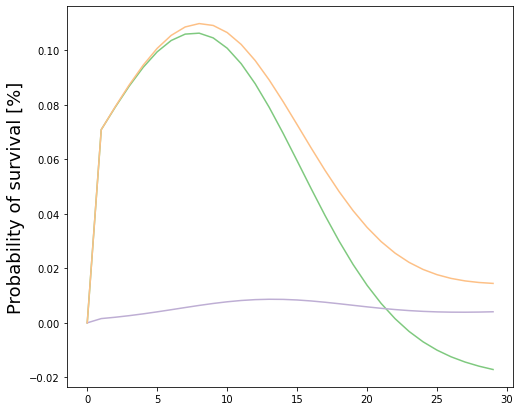

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time[:30]-2011, 
        Model1.oc_due_to_pr[:30,0], label='product')
ax.plot(time[:30]-2011, 
        Model1.oc_both[:30,0], label='both')
ax.plot(time[:30]-2011, 
        Model1.oc_due_to_cm[:30,0], label='component')
ax.set_ylabel('Probability of survival [%]',fontsize =18)

In [20]:
Model3.oc_due_to_pr[:30,0]

array([0.        , 0.0708351 , 0.08048584, 0.09018136, 0.09961455,
       0.10844509, 0.11631661, 0.12287822, 0.12780867, 0.13084136,
       0.13178746, 0.13055437, 0.12715736, 0.12172216, 0.11447812,
       0.10574198, 0.09589403, 0.0853492 , 0.07452633, 0.063819  ,
       0.05357087, 0.04405784, 0.03547823, 0.02795092, 0.02152065,
       0.0161687 , 0.01182697, 0.00839325, 0.00574602, 0.00375724])

Text(0, 0.5, 'Probability of survival [%]')

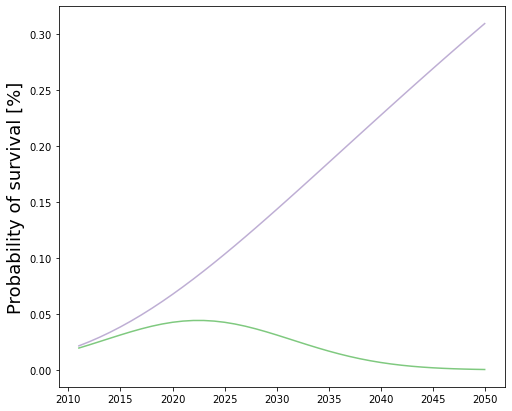

In [21]:
fig, ax = plt.subplots(figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)
ax.plot(time[:40], 
        Model3.sf_pr[:40,0]-Model3.sf_pr[1:41,0], label='Product function')
ax.plot(time[:40], (Model3.sf_pr[:40,0]-Model3.sf_pr[1:41,0])/Model3.sf_pr[:40,0], label='Component function')

ax.set_ylabel('Probability of survival [%]',fontsize =18)


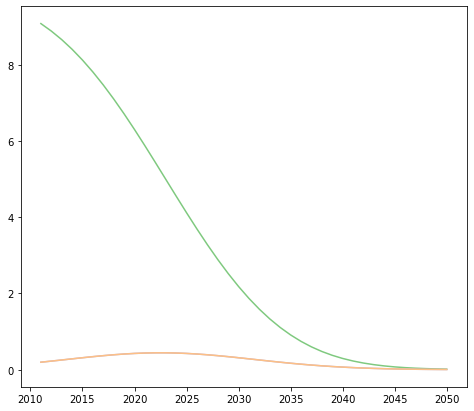

In [22]:
remaining_stock = 10*Model3.sf_pr[:41,0]
fig, ax = plt.subplots(figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)
ax.plot(time[:40], 
        remaining_stock[:40], label='remaining_stock')
ax.plot(time[:40], 
        remaining_stock[:40]*(Model3.sf_pr[:40,0]-Model3.sf_pr[1:41,0])/Model3.sf_pr[:40,0], label='Outflows')
ax.plot(time[:40], 
        remaining_stock[:40]-remaining_stock[1:41], label='outflows from stock')


In [23]:
remaining_stock[:40]*(Model3.sf_pr[:40,0]-Model3.sf_pr[1:41,0])/Model3.sf_pr[:40,0] - (remaining_stock[:40]-remaining_stock[1:41])

array([ 4.44089210e-16, -2.22044605e-16,  0.00000000e+00,  2.22044605e-16,
        0.00000000e+00,  4.44089210e-16,  0.00000000e+00, -8.88178420e-16,
        2.22044605e-16,  3.88578059e-16, -2.22044605e-16,  0.00000000e+00,
        0.00000000e+00, -2.22044605e-16,  4.44089210e-16, -5.55111512e-17,
       -2.22044605e-16,  5.55111512e-17,  1.11022302e-16,  0.00000000e+00,
       -1.11022302e-16,  0.00000000e+00,  1.11022302e-16, -8.32667268e-17,
        5.55111512e-17,  0.00000000e+00, -4.16333634e-17,  2.77555756e-17,
        0.00000000e+00, -1.38777878e-17,  6.93889390e-18,  0.00000000e+00,
       -6.93889390e-18, -3.46944695e-18,  0.00000000e+00,  0.00000000e+00,
        3.46944695e-18,  0.00000000e+00, -8.67361738e-19,  8.67361738e-19])

In [24]:
import numpy as np
import product_component_model as pcm
lt_pr = np.array([16])
sd_pr = np.array([4])
lt_cm = np.array([12])
sd_cm= np.array([3])
Model1 = pcm.ProductComponentModel(t=time, s_pr=data, 
                                   lt_pr={'Type': 'Normal', 'Mean': lt_pr, 'StdDev': sd_pr},
                                   lt_cm={'Type': 'Normal', 'Mean': lt_cm, 'StdDev': sd_cm},
                                   tau_pr=6, tau_cm= 5, reuse_coeff=0.1)
Model1.compute_sf_cm()
Model1.compute_hz_cm()
Model1.compute_sf_pr()
Model1.compute_hz_pr()

array([[3.16712418e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.67478406e-05, 3.16712418e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.44224546e-04, 5.67478406e-05, 3.16712418e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.34696710e-01, 7.18163116e-01, 7.00653004e-01, ...,
        3.16712418e-05, 0.00000000e+00, 0.00000000e+00],
       [7.50300315e-01, 7.34696710e-01, 7.18163116e-01, ...,
        5.67478406e-05, 3.16712418e-05, 0.00000000e+00],
       [7.65019733e-01, 7.50300315e-01, 7.34696710e-01, ...,
        1.44224546e-04, 5.67478406e-05, 3.16712418e-05]])

In [25]:
Model1.hz_pr - Model1.hz_cm

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.44501958e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.62007023e-04, -3.44501958e-05,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.02131801e-01, -2.11353894e-01, -2.20716434e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.93087786e-01, -2.02131801e-01, -2.11353894e-01, ...,
        -3.44501958e-05,  0.00000000e+00,  0.00000000e+00],
       [-1.84252085e-01, -1.93087786e-01, -2.02131801e-01, ...,
        -1.62007023e-04, -3.44501958e-05,  3.16712418e-05]])

In [26]:
Model1.hz_pr[:,0]

array([3.16712418e-05, 5.67478406e-05, 1.44224546e-04, 3.44476099e-04,
       7.73319214e-04, 1.63206833e-03, 3.23955520e-03, 6.05239065e-03,
       1.06559223e-02, 1.77119747e-02, 2.78642633e-02, 4.16233092e-02,
       5.92670284e-02, 8.07898293e-02, 1.05912960e-01, 1.34144861e-01,
       1.64866014e-01, 1.97412651e-01, 2.31142780e-01, 2.65478835e-01,
       2.99928926e-01, 3.34092184e-01, 3.67654099e-01, 4.00376664e-01,
       4.32086601e-01, 4.62663659e-01, 4.92030004e-01, 5.20141090e-01,
       5.46978090e-01, 5.72541756e-01, 5.96847516e-01, 6.19921613e-01,
       6.41798074e-01, 6.62516366e-01, 6.82119574e-01, 7.00653004e-01,
       7.18163116e-01, 7.34696710e-01, 7.50300315e-01, 7.65019733e-01])

In [27]:
pz_cm = np.zeros((len(Model1.t), len(Model1.t)))
    # Perform specific computations and checks for each lifetime distribution:
#pz_cm [0::,0] = (1 - Model1.sf_cm[0::,0]) / Model1.sf_cm[0::,0]
for m in range(0, len(Model1.t)-1): 
    pz_cm [m:-1,m] = (Model1.sf_cm[m:-1,m] - Model1.sf_cm[m+1::,m]) / Model1.sf_cm[m:-1,m]        

In [28]:
pz_cm = np.zeros((len(Model1.t), len(Model1.t)))
    # Perform specific computations and checks for each lifetime distribution:
#pz_cm [0::,0] = (1 - Model1.sf_cm[0::,0]) / Model1.sf_cm[0::,0]


for m in range(0, len(Model1.t)-1): 
    pz_cm [m,m] = 1-Model1.sf_cm[m,m]
    pz_cm [m+1:,m] = (Model1.sf_cm[m:-1,m] - Model1.sf_cm[m+1::,m]) / Model1.sf_cm[m:-1,m] 

In [29]:
m = 2
Model1.sf_cm[:,m]


array([0.00000000e+00, 0.00000000e+00, 9.99968329e-01, 9.99877134e-01,
       9.99570940e-01, 9.98650102e-01, 9.96169619e-01, 9.90184671e-01,
       9.77249868e-01, 9.52209648e-01, 9.08788780e-01, 8.41344746e-01,
       7.47507462e-01, 6.30558660e-01, 5.00000000e-01, 3.69441340e-01,
       2.52492538e-01, 1.58655254e-01, 9.12112197e-02, 4.77903523e-02,
       2.27501319e-02, 9.81532863e-03, 3.83038057e-03, 1.34989803e-03,
       4.29060333e-04, 1.22866390e-04, 3.16712418e-05, 7.34342384e-06,
       1.53062674e-06, 2.86651572e-07, 4.82130337e-08, 7.28011007e-09,
       9.86587645e-10, 1.19960226e-10, 1.30839247e-11, 1.27981254e-12,
       1.12248813e-13, 8.82618716e-15, 6.22096057e-16, 3.92987343e-17])

In [30]:
(sc_pr, i_pr, i_cm, o_pr, o_cm) = Model1.case_3()
(sc_prn, i_prn, i_cmn, o_prn, o_cmn) = Model1.case_3_new()

In [31]:
i_prn -i_pr

array([1.06303936e-04, 1.73428427e-05, 4.26716183e-05, 6.28462394e-05,
       9.37365388e-05, 1.41135463e-04, 2.13683118e-04, 3.23956108e-04,
       4.89806927e-04, 7.35895782e-04, 1.09516677e-03, 1.60956164e-03,
       2.32818892e-03, 3.29951629e-03, 4.55280304e-03, 6.06607286e-03,
       7.72816582e-03, 9.32045973e-03, 1.05545742e-02, 1.11788177e-02,
       1.11038030e-02, 1.04563754e-02, 9.51797259e-03, 8.59803119e-03,
       7.92963594e-03, 7.62964879e-03, 7.70904353e-03, 8.10214037e-03,
       8.69595284e-03, 9.35567937e-03, 9.94870238e-03, 1.03681967e-02,
       1.05530902e-02, 1.04988868e-02, 1.02551462e-02, 9.90954146e-03,
       9.56309501e-03, 9.30435124e-03, 9.18998546e-03, 4.28047364e-03])

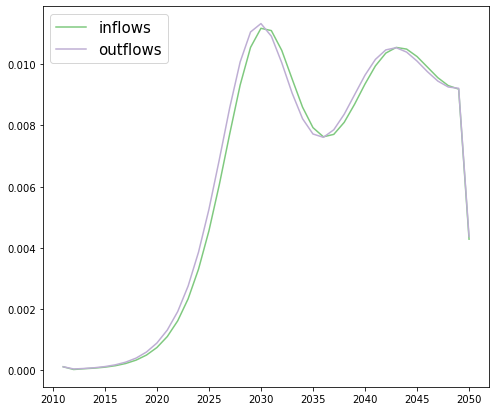

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 6)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time, 
       i_prn -i_pr, label='inflows')
ax.plot(time, 
       o_prn -o_pr, label='outflows')
ax.legend(loc='upper left',prop={'size':15})

In [33]:
i_prn - o_prn - Model1.ds_pr

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.84217094e-14,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.42108547e-14,  2.84217094e-14,  0.00000000e+00,
        1.42108547e-14,  0.00000000e+00,  2.84217094e-14,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.84217094e-14,  0.00000000e+00,
        2.84217094e-14, -2.84217094e-14, -2.84217094e-14,  2.84217094e-14])

In [34]:
diff = np.zeros(len(Model1.t))
for m in range (len(Model1.t)):
    diff[m] = np.sum(sc_pr[m,:m]) - np.sum(Model1.s_tpc[m,:m,:])
print(diff)

[0.00000000e+00 0.00000000e+00 1.73419246e-05 2.53220091e-05
 3.74988541e-05 5.61659258e-05 8.47882934e-05 1.28479756e-04
 1.94607797e-04 2.93527754e-04 4.39387941e-04 6.50805756e-04
 9.50886165e-04 1.36530861e-03 1.91632738e-03 2.61009373e-03
 3.41724039e-03 4.25435492e-03 4.98430969e-03 5.45380852e-03
 5.56260703e-03 5.32045616e-03 4.84489778e-03 4.30280460e-03
 3.84307933e-03 3.55978729e-03 3.48811719e-03 3.61617850e-03
 3.89861077e-03 4.26834808e-03 4.64792792e-03 4.96289024e-03
 5.15633606e-03 5.20121375e-03 5.10584088e-03 4.91028529e-03
 4.67429164e-03 4.46078636e-03 4.32027776e-03 4.28049502e-03]


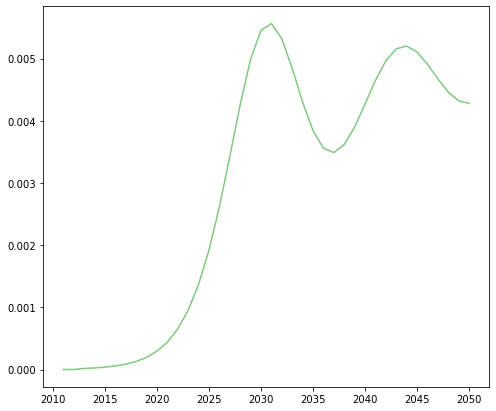

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 6)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time, diff, label='stock')

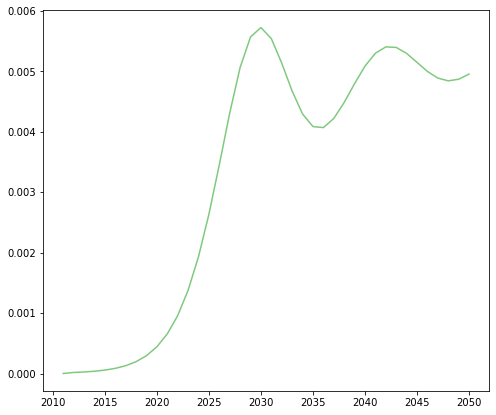

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 6)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time, sc_pr[:,:].sum(axis=1) - Model1.s_tpc[:,:,:].sum(axis=1).sum(axis=1), label='stock')

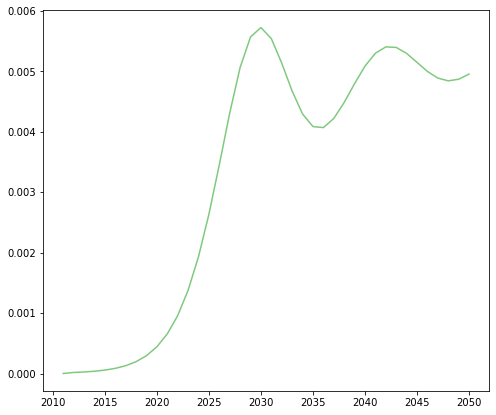

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 6)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time, sc_pr[:,:].sum(axis=1) - Model1.s_pr, label='stock')

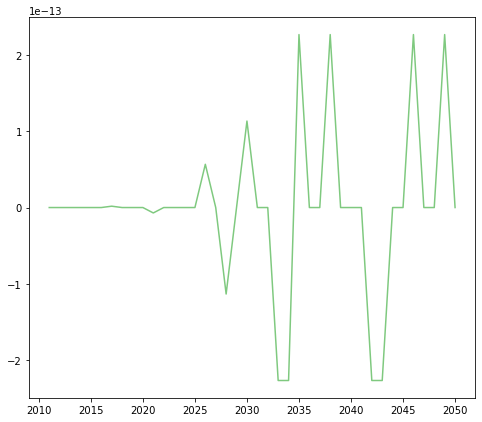

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 6)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time, Model1.s_tpc[:,:,:].sum(axis=1).sum(axis=1) - Model1.s_pr, label='stock')

In [39]:
Model1.ds_pr[:] + Model1.o_tpc[:,:,:].sum(axis=1).sum(axis=1) -i_pr      

array([1.06303936e-04, 1.73428427e-05, 4.26716183e-05, 6.28462394e-05,
       9.37365388e-05, 1.41135463e-04, 2.13683118e-04, 3.23956108e-04,
       4.89806927e-04, 7.35895782e-04, 1.09516677e-03, 1.60956164e-03,
       2.32818892e-03, 3.29951629e-03, 4.55280304e-03, 6.06607286e-03,
       7.72816582e-03, 9.32045973e-03, 1.05545742e-02, 1.11788177e-02,
       1.11038030e-02, 1.04563754e-02, 9.51797259e-03, 8.59803119e-03,
       7.92963594e-03, 7.62964879e-03, 7.70904353e-03, 8.10214037e-03,
       8.69595284e-03, 9.35567937e-03, 9.94870238e-03, 1.03681967e-02,
       1.05530902e-02, 1.04988868e-02, 1.02551462e-02, 9.90954146e-03,
       9.56309501e-03, 9.30435124e-03, 9.18998546e-03, 4.28047364e-03])

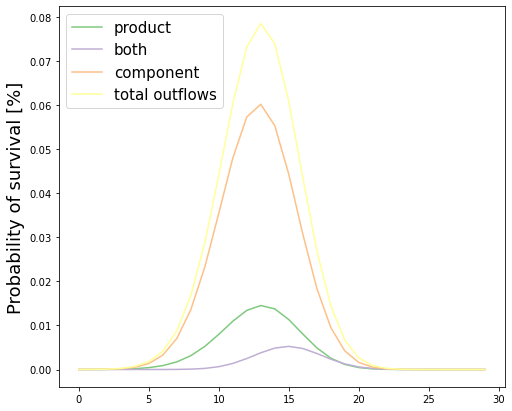

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 6)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time[:30]-2011, 
        Model1.o_tpc_pr[:30,1,:].sum(axis=1), label='product')
ax.plot(time[:30]-2011, 
        Model1.o_tpc_both[:30,1,:].sum(axis=1), label='both')
ax.plot(time[:30]-2011, 
        Model1.o_tpc_cm[:30,1,:].sum(axis=1), label='component')
ax.plot(time[:30]-2011, 
        Model1.o_tpc[:30,1,:].sum(axis=1), label='total outflows')
ax.set_ylabel('Probability of survival [%]',fontsize =18)
ax.legend(loc='upper left',prop={'size':15})

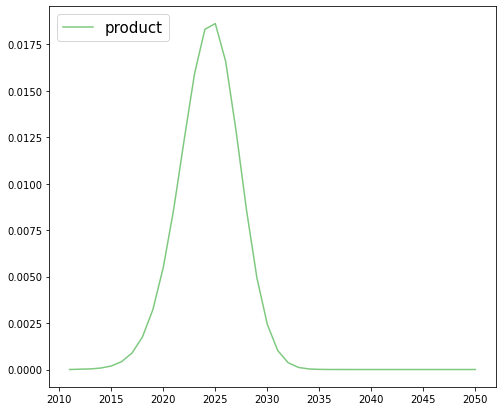

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time, 
        (Model1.o_tpc[:,1,:] - Model1.o_tpc_cm[:,1,:]).sum(axis=1), label='product')

ax.legend(loc='upper left',prop={'size':15})

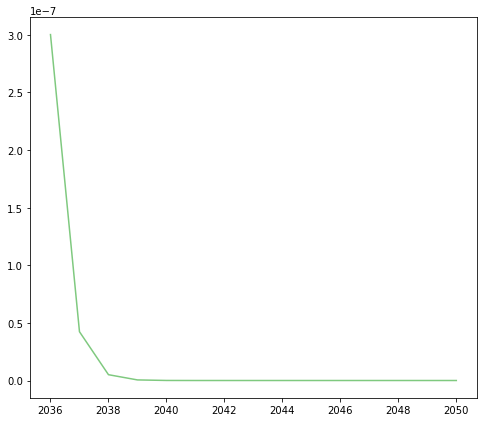

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)
ax.plot(time[25:], 
        Model1.o_tpc_pr[25:,1,:].sum(axis=1), label='product')

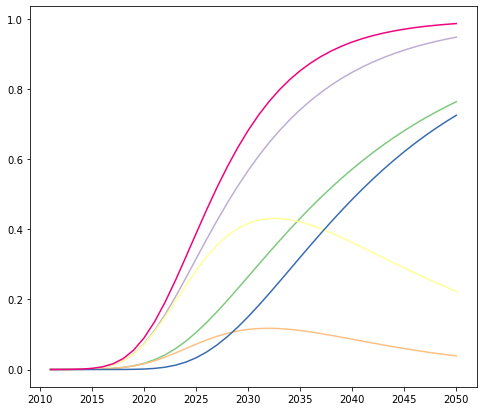

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)
ax.plot(time, 
        Model1.hz_pr[:,0], label='product')
ax.plot(time, 
        Model1.hz_cm[:,0], label='product')
ax.plot(time, 
        Model1.hz_pr[:,0]*(1-Model1.hz_cm[:,0]), label='product')
ax.plot(time, 
        Model1.hz_cm[:,0]*(1-Model1.hz_pr[:,0]), label='product')
ax.plot(time, 
        Model1.hz_cm[:,0]*Model1.hz_pr[:,0], label='product')
ax.plot(time, 
        Model1.hz_cm[:,0]*Model1.hz_pr[:,0] + Model1.hz_pr[:,0]*(1-Model1.hz_cm[:,0])+Model1.hz_cm[:,0]*(1-Model1.hz_pr[:,0]), label='product')

In [44]:
Model1.s_tpc[25:,10,:].sum(axis=1)

array([1.96700929e+00, 9.44400858e-01, 3.97137275e-01, 1.45355020e-01,
       4.60633241e-02, 1.25844572e-02, 2.95330051e-03, 5.93580670e-04,
       1.01923190e-04, 1.49206285e-05, 1.85894625e-06, 1.96822886e-07,
       1.76878151e-08, 1.34773196e-09, 8.69902768e-11])

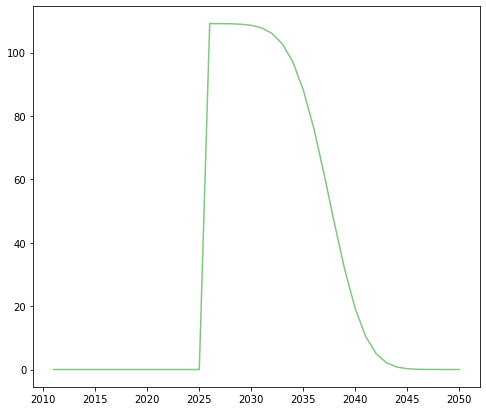

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time, 
        Model1.s_tpc[:,15,:].sum(axis=1), label='stock')

In [58]:
Model1.hz_pr[0,0]

3.167124183311998e-05

In [60]:
1-Model1.sf_pr[0,0]

3.167124183311998e-05

In [46]:
m=5
Model1.s_tpc[m+1,1,:m+1]


array([0.        , 0.54066765, 0.        , 0.        , 0.        ,
       0.        ])

In [47]:
m=2

Model1.o_tpc_pr[m,:m+1,:m+1] + Model1.o_tpc_cm[m,:m+1,:m+1] - Model1.o_tpc_both[m,:m+1,:m+1]
Model1.o_tpc[m,:m+1,:m+1]

array([[1.51167145e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.10159216e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.06606957e-05]])

In [48]:
m=6

Model1.i_pr[:m+1]

array([3.35690669, 0.54765898, 0.7998535 , 1.1849293 , 1.7758578 ,
       2.68314465, 4.07020569])

In [49]:
Model1.s_tpc[:,:m,:3]

array([[[3.35669407e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[3.35619748e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.47624289e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[3.35468581e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.47543273e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.99802834e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0

In [50]:
pz_cm[:,m]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.16712418e-05, 9.11980365e-05,
       3.06231569e-04, 9.21232963e-04, 2.48383546e-03, 6.00796084e-03,
       1.30630212e-02, 2.56231504e-02, 4.56001129e-02, 7.42131017e-02,
       1.11532501e-01, 1.56451686e-01, 2.07052362e-01, 2.61117320e-01,
       3.16555810e-01, 3.71643790e-01, 4.25098019e-01, 4.76047438e-01,
       5.23959735e-01, 5.68559486e-01, 6.09755240e-01, 6.47581224e-01,
       6.82153523e-01, 7.13638432e-01, 7.42230224e-01, 7.68135905e-01,
       7.91564974e-01, 8.12722746e-01, 8.31806142e-01, 8.49001203e-01,
       8.64481768e-01, 8.78408952e-01, 8.90931144e-01, 9.02184354e-01])

In [51]:
stock = 1
for m in range(len(Model1.t)):
    stock -= stock * pz_cm[m,2]
    stock2 = Model1.sf_cm[m,2]
    print(stock-stock2)

1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.336808689942018e-19
6.505213034913027e-19
2.168404344971009e-19
1.3552527156068805e-19
3.3881317890172014e-20
1.0164395367051604e-20
2.752857078576476e-21
3.705769144237564e-22
5.293955920339377e-23
8.271806125530277e-24
1.0339757656912846e-24
5.169878828456423e-26
6.462348535570529e-27
-8.077935669463161e-28
-2.145701662201152e-28
-2.3665827156630354e-29
-1.7749370367472766e-30
-1.2942249226282225e-31


In [52]:
10*Model1.sf_cm[:,0]

array([9.99968329e+00, 9.99877134e+00, 9.99570940e+00, 9.98650102e+00,
       9.96169619e+00, 9.90184671e+00, 9.77249868e+00, 9.52209648e+00,
       9.08788780e+00, 8.41344746e+00, 7.47507462e+00, 6.30558660e+00,
       5.00000000e+00, 3.69441340e+00, 2.52492538e+00, 1.58655254e+00,
       9.12112197e-01, 4.77903523e-01, 2.27501319e-01, 9.81532863e-02,
       3.83038057e-02, 1.34989803e-02, 4.29060333e-03, 1.22866390e-03,
       3.16712418e-04, 7.34342384e-05, 1.53062674e-05, 2.86651572e-06,
       4.82130337e-07, 7.28011007e-08, 9.86587645e-09, 1.19960226e-09,
       1.30839247e-10, 1.27981254e-11, 1.12248813e-12, 8.82618716e-14,
       6.22096057e-15, 3.92987343e-16, 2.22477598e-17, 1.12858841e-18])

In [53]:
Model1.pz_cm[m::,m].shape

AttributeError: 'ProductComponentModel' object has no attribute 'pz_cm'

In [ ]:
### remaining_stock = 10*Model3.sf_pr[:41,0]
fig, ax = plt.subplots(figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)

ax.plot(time[:40], 
        pz_cm[:,0], label='Outflows')


In [ ]:
remaining_stock2 = np.zeros([41])
remaining_stock2[0] = 10
remaining_stock2[1:] = remaining_stock[:40]
### remaining_stock = 10*Model3.sf_pr[:41,0]
fig, ax = plt.subplots(figsize=(8,7))
lt_colors = cycler(color=sns.color_palette('Accent', 20)) #'Set2', 'Paired', 'YlGnBu'
ax.set_prop_cycle(lt_colors)
ax.plot(time[:40], 
        remaining_stock2[:40], label='remaining_stock')
#ax.plot(time[:40], 
#        remaining_stock2[:40]*pz_cm[:,0], label='Outflows')
#ax.plot(time[:40], 
#        remaining_stock2[:40]-remaining_stock2[1:41], label='outflows from stock')
ax.plot(time[:40], 
        10*Model1.sf_cm[:,0], label='outflows from stock')



In [ ]:
Model3.s_pr

In [ ]:
remaining_stock2

In [ ]:
remaining_stock[:40]*Model1.pz_cm[:,1]-(remaining_stock2[:40]-remaining_stock2[1:41])

In [ ]:
10 - np.sum(remaining_stock[:40]*pz_cm[:,0])

In [ ]:
10 - np.sum(

In [ ]:
remaining_stock2

In [ ]:
remaining_stock